In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, recall_score, f1_score,
                             roc_curve, accuracy_score, precision_recall_fscore_support, precision_score)
from imblearn.combine import SMOTETomek
import xgboost as xgb

In [2]:
# Loading the dataset
df = pd.read_excel("/Users/pragathi/Downloads/market_regime.xlsx")
df.head()

,Date,SPY_ret,VIX,Yield_Curve,Credit_Spread,TLT_SPY_ratio,Regime,y
0,2002-07-30,1.2949,31.92,2.93,328.51,0.626618,Bear,0
1,2002-07-31,0.2417,32.03,2.80,328.54,0.632851,Bear,0
2,2002-08-01,-2.6455,36.95,2.79,330.94,0.653517,Bear,0
3,2002-08-02,-2.2670,41.29,2.70,329.88,0.675347,Bear,0
4,2002-08-05,-3.5417,45.08,2.65,328.64,0.702782,Bear,0


In [3]:
# Converting 'Date' column to datetime and sorting chronologically
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [4]:
print("Rows:", len(df))
print("Date range:", df['Date'].min().date(), "to", df['Date'].max().date())
print("Columns:", df.columns.tolist())

Rows: 5822
Date range: 2002-07-30 to 2025-09-17
Columns: ['Date', 'SPY_ret', 'VIX', 'Yield_Curve', 'Credit_Spread', 'TLT_SPY_ratio', 'Regime', 'y']


In [5]:
# Checking class distribution of the target variable 'y'
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=False))      # Count of each class


Target distribution:
y
1    5195
0     627
Name: count, dtype: int64


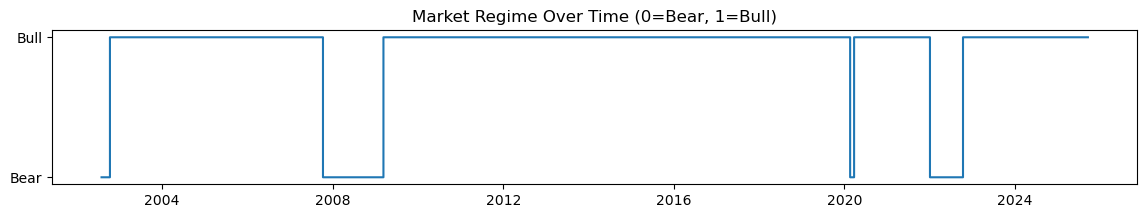

Target counts:
 y
1    5195
0     627
Name: count, dtype: int64


In [6]:
# EDA plots

# Plot market regime over time to see bull/bear transitions
df_plot = df.set_index('Date')
plt.figure(figsize=(14,2))
plt.plot(df_plot.index, df_plot['y'], drawstyle='steps-post')
plt.yticks([0,1], ['Bear','Bull'])
plt.title("Market Regime Over Time (0=Bear, 1=Bull)")
plt.show()

# Check class distribution to understand imbalance
print("Target counts:\n", df['y'].value_counts())


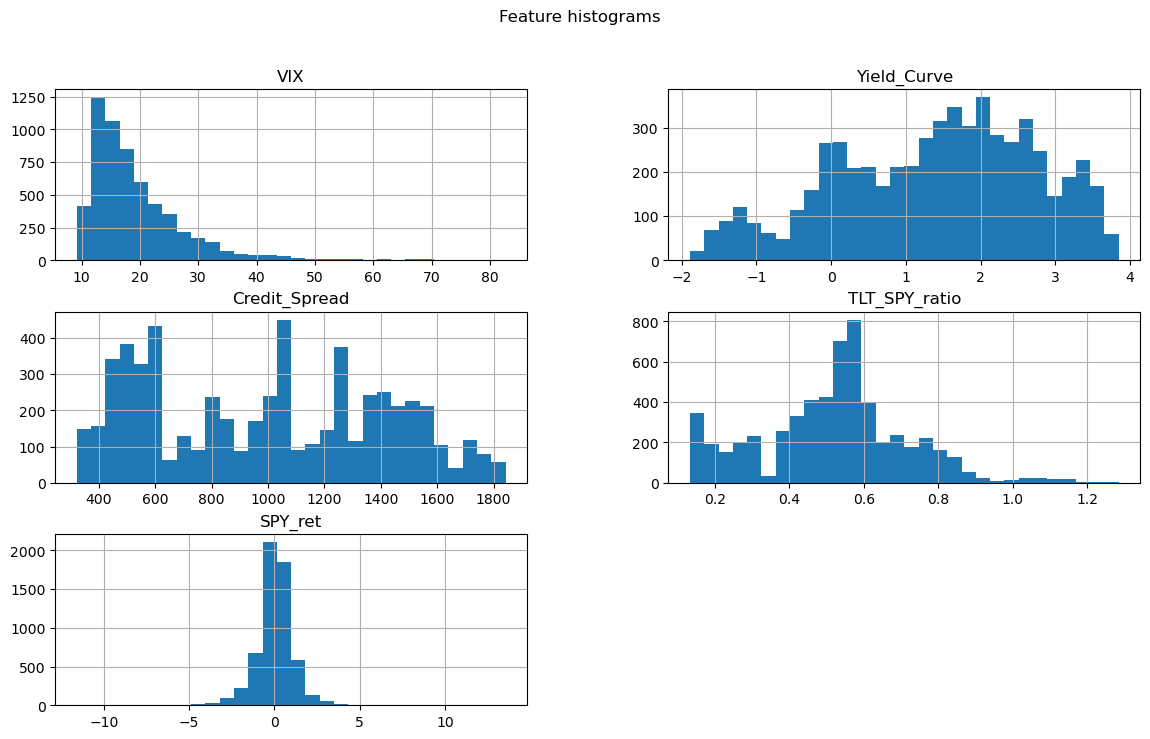

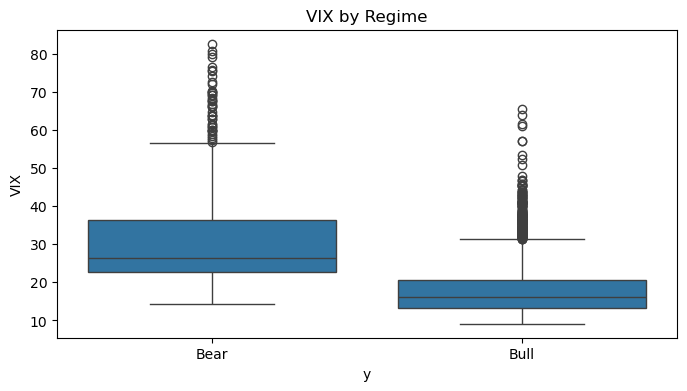

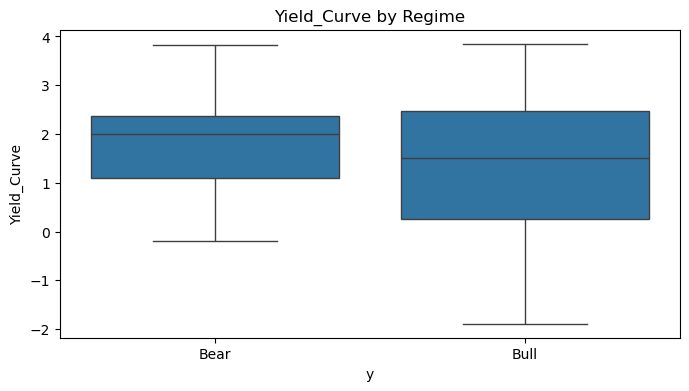

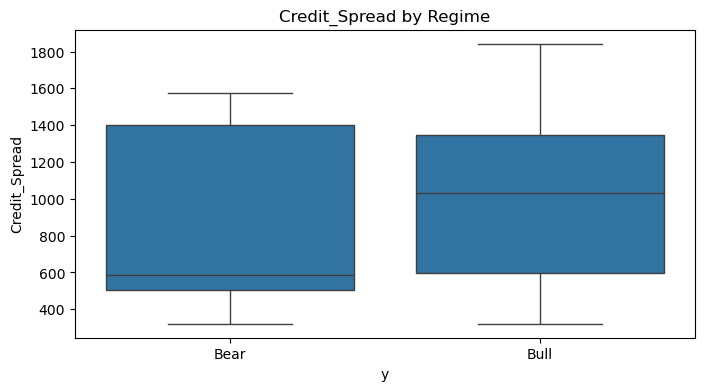

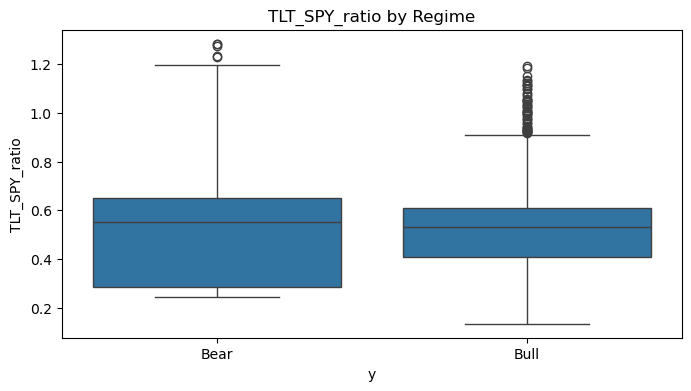

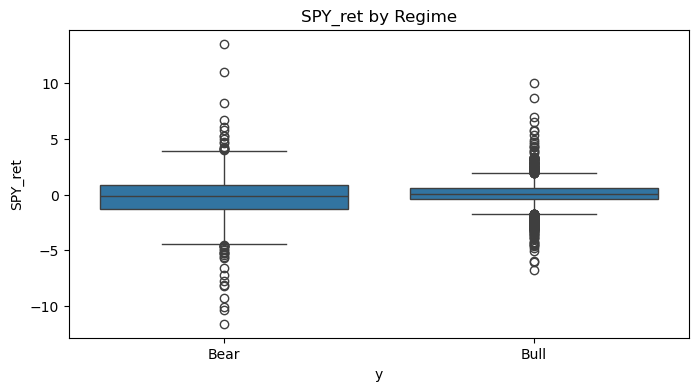

In [7]:
# Feature distributions 

# Select numerical features for analysis
features = ['VIX','Yield_Curve','Credit_Spread','TLT_SPY_ratio','SPY_ret']

# Plot histograms to examine the distribution of each feature
df[features].hist(bins=30, figsize=(14,8))
plt.suptitle("Feature histograms")
plt.show()

# Compare each feature across Bear (0) and Bull (1) regimes using boxplots
for col in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='y', y=col, data=df)
    plt.xticks([0,1], ['Bear','Bull'])   # Rename classes for readability
    plt.title(f"{col} by Regime")
    plt.show()

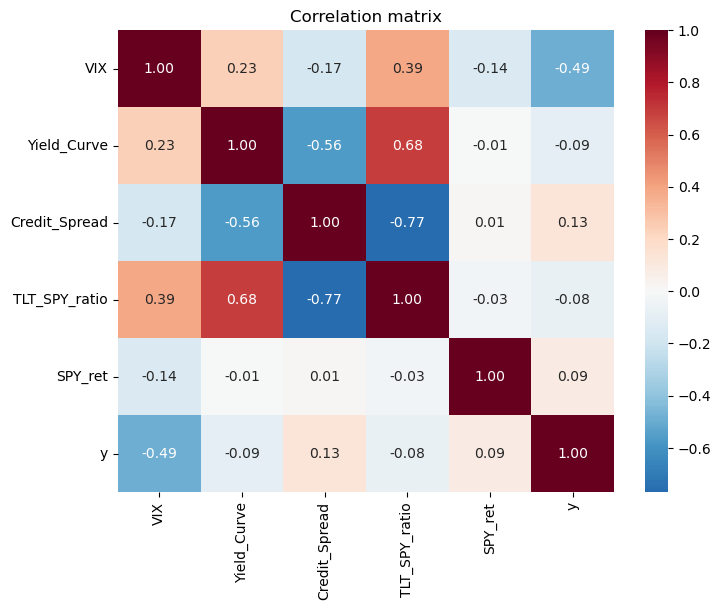

In [8]:
# Compute and visualize correlations between features and the target
plt.figure(figsize=(8,6))
sns.heatmap(df[features + ['y']].corr(), annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title("Correlation matrix")
plt.show()

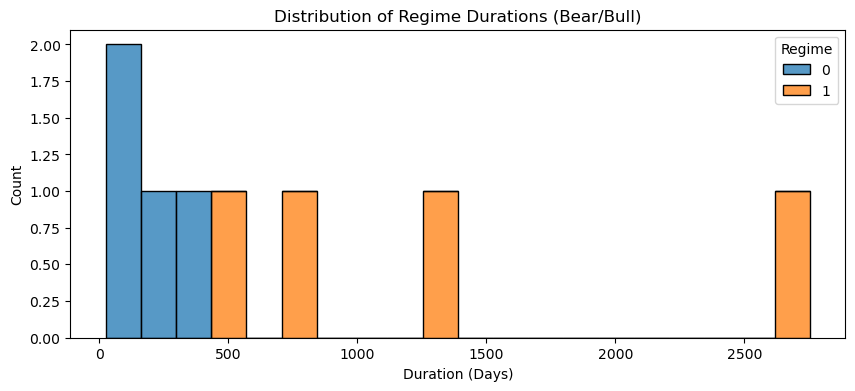

        count     mean          std    min     25%    50%     75%     max
Regime                                                                   
0         4.0   156.75   152.803523   24.0   44.25  123.5   236.0   356.0
1         4.0  1298.75  1026.876291  449.0  662.75  995.5  1631.5  2755.0


In [9]:
# Calculate and visualize regime durations
df['Regime_Change'] = df['y'].diff()
regime_lengths = df.groupby((df['Regime_Change'] != 0).cumsum()).agg({'y':'first', 'Date':['first','last','count']})
regime_lengths.columns = ['Regime','Start_Date','End_Date','Length']

plt.figure(figsize=(10,4))
sns.histplot(data=regime_lengths, x='Length', hue='Regime', bins=20, multiple='stack')
plt.title("Distribution of Regime Durations (Bear/Bull)")
plt.xlabel("Duration (Days)")
plt.show()

print(regime_lengths.groupby('Regime')['Length'].describe())

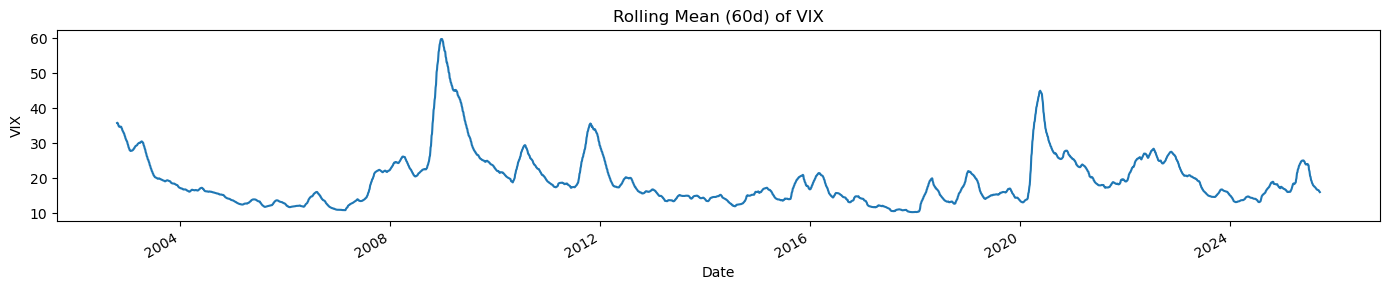

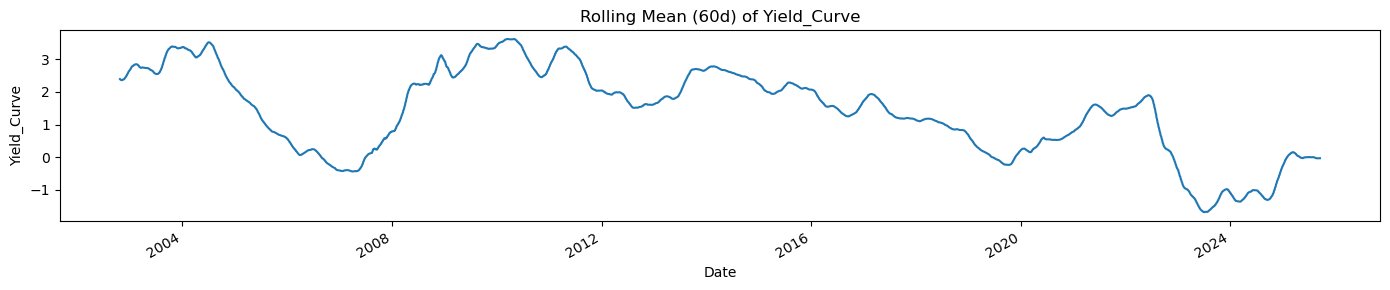

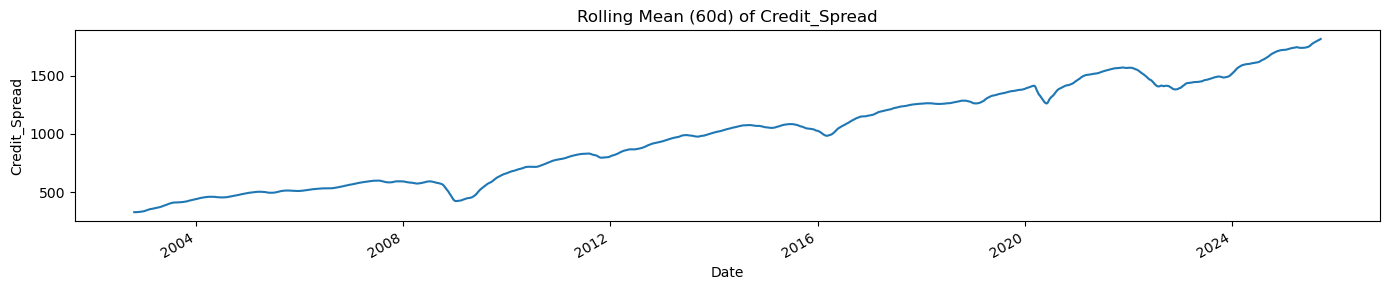

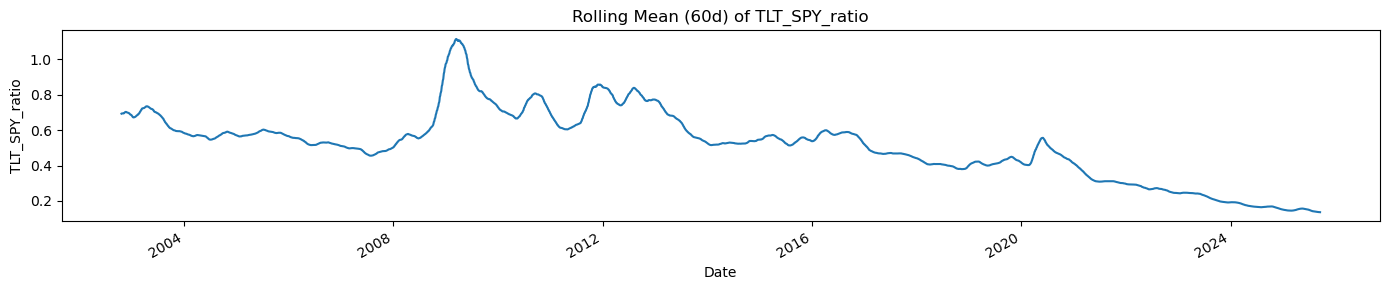

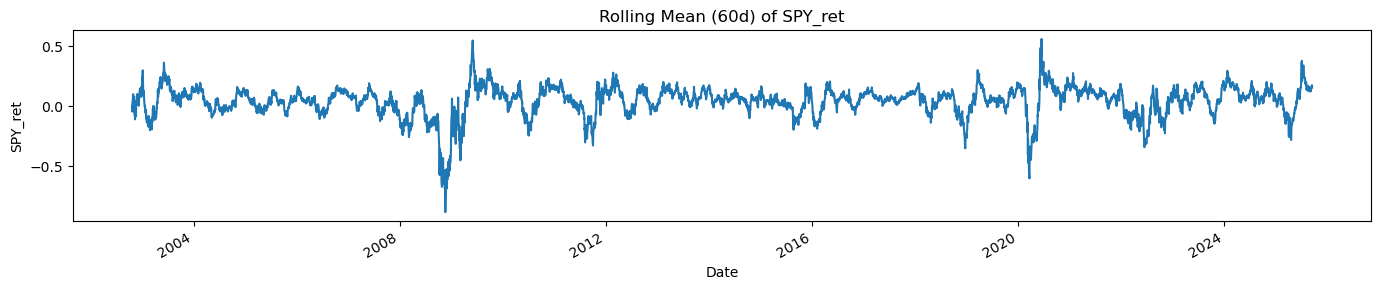

In [10]:
# Rolling mean for smoother trends
window = 60  # approx 3 months
for col in features:
    plt.figure(figsize=(14,3))
    df_plot[col].rolling(window).mean().plot()
    plt.title(f'Rolling Mean ({window}d) of {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [11]:
# Regime Feature Means & Comparison Table
summary_stats = df.groupby('y')[features].agg(['mean','median','std'])
print(summary_stats)

         VIX                   Yield_Curve                  Credit_Spread  \
        mean median        std        mean median       std          mean   
y                                                                           
0  31.389203  26.40  13.255314    1.760558    2.0  0.887638    838.452169   
1  17.929798  16.23   6.481549    1.354803    1.5  1.374590   1012.268700   

                       TLT_SPY_ratio                       SPY_ret          \
    median         std          mean    median       std      mean  median   
y                                                                            
0   588.66  450.688069      0.560367  0.553156  0.261641 -0.256752 -0.1245   
1  1033.81  404.631081      0.512523  0.531506  0.187442  0.077584  0.0824   

             
        std  
y            
0  2.288630  
1  0.980448  


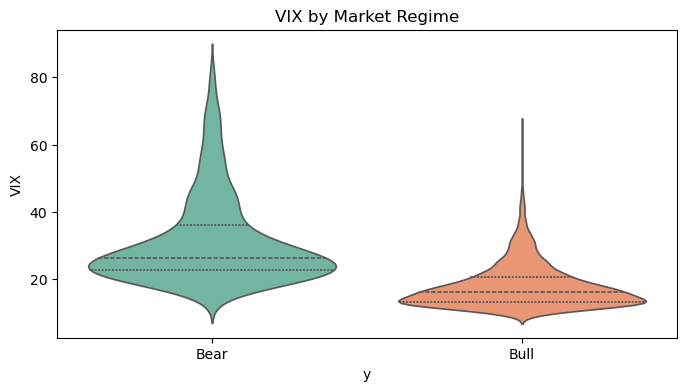

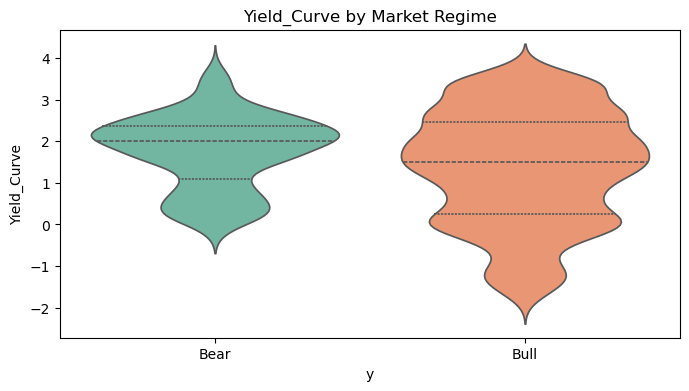

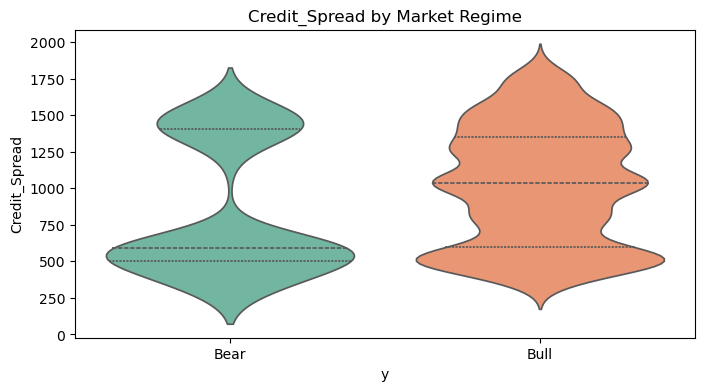

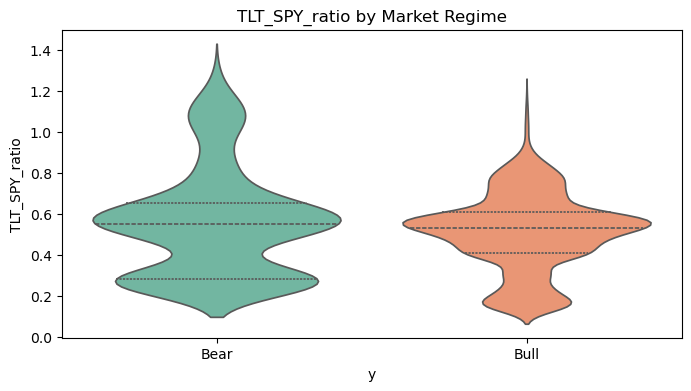

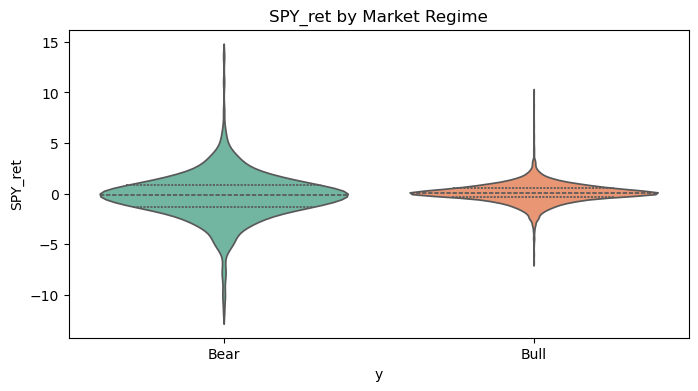

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['VIX', 'Yield_Curve', 'Credit_Spread', 'TLT_SPY_ratio', 'SPY_ret']

for col in features:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x='y', y=col, data=df, inner='quartile', hue='y', palette='Set2', legend=False)
    plt.xticks([0, 1], ['Bear', 'Bull'])
    plt.title(f"{col} by Market Regime")
    plt.show()

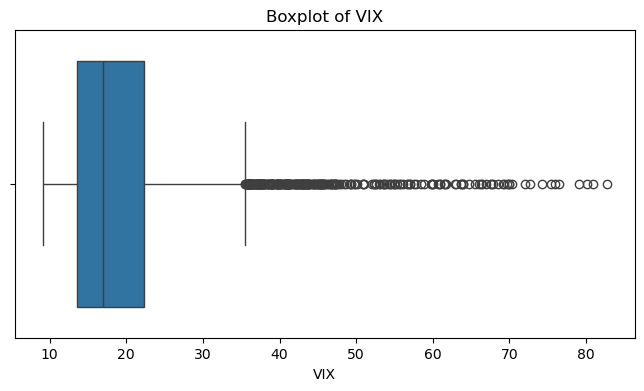

VIX percentiles:
 count    5822.000000
mean       19.379308
std         8.590242
min         9.140000
1%          9.962100
5%         11.220500
25%        13.622500
50%        16.950000
75%        22.367500
95%        34.779500
99%        54.422200
max        82.690000
Name: VIX, dtype: float64 



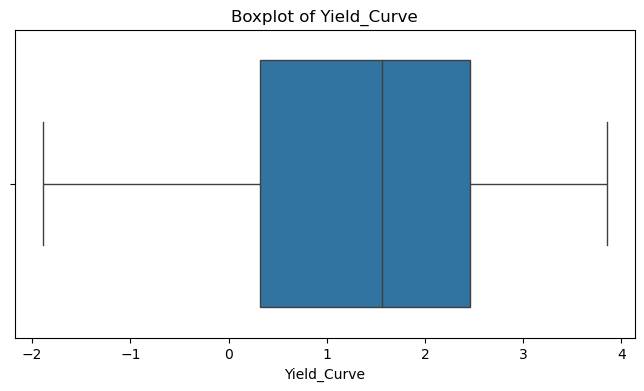

Yield_Curve percentiles:
 count    5822.000000
mean        1.398501
std         1.336611
min        -1.890000
1%         -1.610000
5%         -1.140000
25%         0.320000
50%         1.560000
75%         2.460000
95%         3.400000
99%         3.660000
max         3.850000
Name: Yield_Curve, dtype: float64 



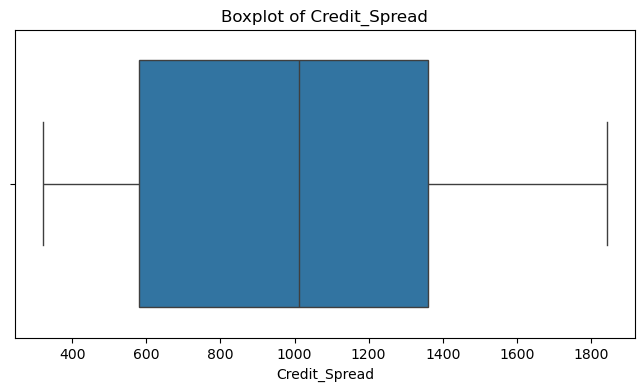

Credit_Spread percentiles:
 count    5822.000000
mean      993.549537
std       413.326035
min       321.240000
1%        336.146500
5%        419.155000
25%       580.687500
50%      1013.175000
75%      1360.705000
95%      1656.257500
99%      1789.923000
max      1842.530000
Name: Credit_Spread, dtype: float64 



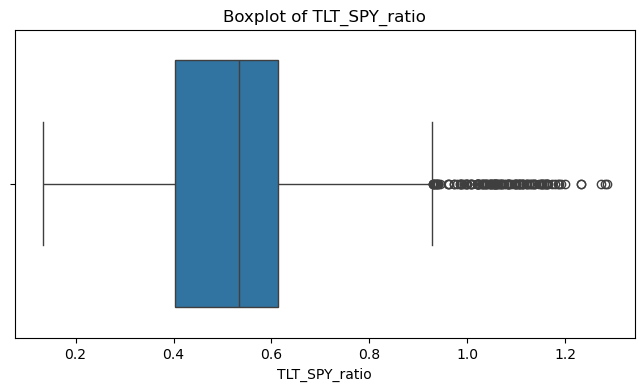

TLT_SPY_ratio percentiles:
 count    5822.000000
mean        0.517675
std         0.197311
min         0.133412
1%          0.141038
5%          0.166845
25%         0.403983
50%         0.533169
75%         0.613936
95%         0.830299
99%         1.066921
max         1.284817
Name: TLT_SPY_ratio, dtype: float64 



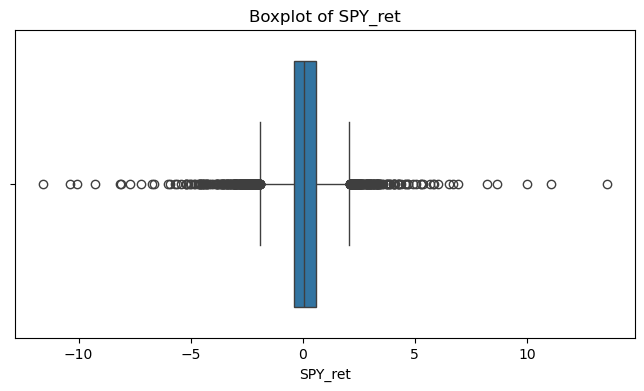

SPY_ret percentiles:
 count    5822.000000
mean        0.041577
std         1.196563
min       -11.588600
1%         -3.496897
5%         -1.789655
25%        -0.411125
50%         0.072850
75%         0.587975
95%         1.649675
99%         3.180424
max        13.557800
Name: SPY_ret, dtype: float64 



In [13]:
# Outlier Detection
for col in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()
    print(f"{col} percentiles:\n", df[col].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]), "\n")

In [14]:
# Simple transition count matrix
transition_matrix = pd.crosstab(df['y'].shift(), df['y'])
print("Transition Matrix (Previous Regime vs. Next):\n", transition_matrix)

Transition Matrix (Previous Regime vs. Next):
 y      0     1
y             
0.0  623     4
1.0    3  5191


In [15]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Date             0
SPY_ret          0
VIX              0
Yield_Curve      0
Credit_Spread    0
TLT_SPY_ratio    0
Regime           0
y                0
Regime_Change    1
dtype: int64


In [16]:
# Plotting + Helper Functions
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12,6)

# Reusable evaluation function
def eval_classification(y_true, y_pred, y_prob=None, positive_label=0):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    auc = None
    if y_prob is not None:
        auc = roc_auc_score((y_true==positive_label).astype(int), y_prob)
    return {'confusion_matrix': cm, 'report': report, 'roc_auc': auc}

def plot_roc(y_true, y_prob, label='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_true, y_prob):.3f})")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def print_roc_auc_both_classes(y_true, prob_bear, model_name=''):
    prob_bull = 1 - prob_bear
    auc_bear = roc_auc_score((y_true==0).astype(int), prob_bear)
    auc_bull = roc_auc_score((y_true==1).astype(int), prob_bull)
    print(f"{model_name} ROC-AUC (Bear=Positive): {auc_bear:.3f}")
    print(f"{model_name} ROC-AUC (Bull=Positive): {auc_bull:.3f}")

In [17]:
# create lag features and perform time-based split
df = df.copy()
df['SPY_ret_lag1'] = df['SPY_ret'].shift(1)     # add 1-day lag
df = df.dropna().reset_index(drop=True)         # remove first NaN row

# Features and target
feature_cols = ['VIX','Yield_Curve','Credit_Spread','TLT_SPY_ratio','SPY_ret_lag1']
X = df[feature_cols]
y = df['y']

# Time-based split ranges
train_end = '2018-12-31'
val_end   = '2021-12-31'

# Split into train/val/test by date 
train_idx = df['Date'] <= train_end
val_idx   = (df['Date'] > train_end) & (df['Date'] <= val_end)
test_idx  = df['Date'] > val_end

# Split the dataset using the masks
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train target distribution:\n", y_train.value_counts())
print("Val target distribution:\n", y_val.value_counts())
print("Test target distribution:\n", y_test.value_counts())

# SMOTETomek on Training Data 
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
print("After SMOTETomek resampling:", pd.Series(y_train_res).value_counts())

# Scale features only for linear models
scaler = StandardScaler()
X_train_res_s = scaler.fit_transform(X_train_res)  # 🔁 CHANGED: fit on resampled train
X_val_s       = scaler.transform(X_val)
X_test_s      = scaler.transform(X_test)

Train/Val/Test shapes: (4134, 5) (757, 5) (930, 5)
Train target distribution:
 y
1    3728
0     406
Name: count, dtype: int64
Val target distribution:
 y
1    733
0     24
Name: count, dtype: int64
Test target distribution:
 y
1    734
0    196
Name: count, dtype: int64
After SMOTETomek resampling: y
0    3720
1    3720
Name: count, dtype: int64


In [18]:
# Logistic Regression
# We'll emphasize detecting Bear (y=0). sklearn uses class_weight for class labels; here majority is 1.
# Using 'balanced' to automatically weight inversely proportional to class freq.
log_clf = LogisticRegression(class_weight=None, max_iter=1000, solver='liblinear')
log_clf.fit(X_train_res_s, y_train_res)

# Predictions on validation set
y_val_pred = log_clf.predict(X_val_s)
y_val_prob = log_clf.predict_proba(X_val_s)[:, 0]  # Probability for bear (class 0)

In [19]:
# Evaluate the model
print("\n=== Logistic Regression with SMOTETomek (Validation) ===")
res_log = eval_classification(y_val, y_val_pred, y_prob=y_val_prob, positive_label=0)
print(res_log['confusion_matrix'])
print(res_log['report'])
print_roc_auc_both_classes(y_val, y_val_prob, model_name='Logistic (SMOTETomek)')


=== Logistic Regression with SMOTETomek (Validation) ===
[[ 18   6]
 [ 88 645]]
              precision    recall  f1-score   support

           0     0.1698    0.7500    0.2769        24
           1     0.9908    0.8799    0.9321       733

    accuracy                         0.8758       757
   macro avg     0.5803    0.8150    0.6045       757
weighted avg     0.9648    0.8758    0.9113       757

Logistic (SMOTETomek) ROC-AUC (Bear=Positive): 0.865
Logistic (SMOTETomek) ROC-AUC (Bull=Positive): 0.865


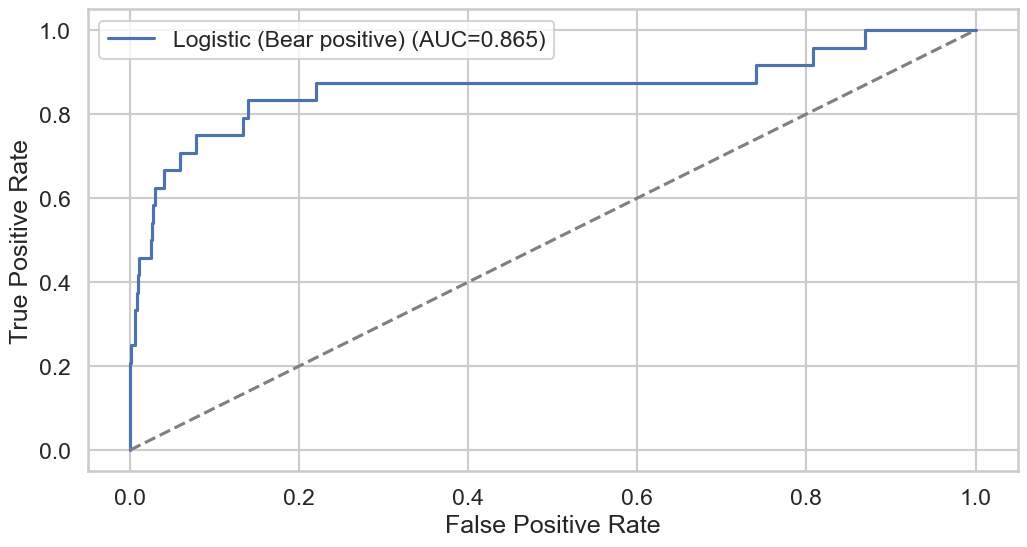

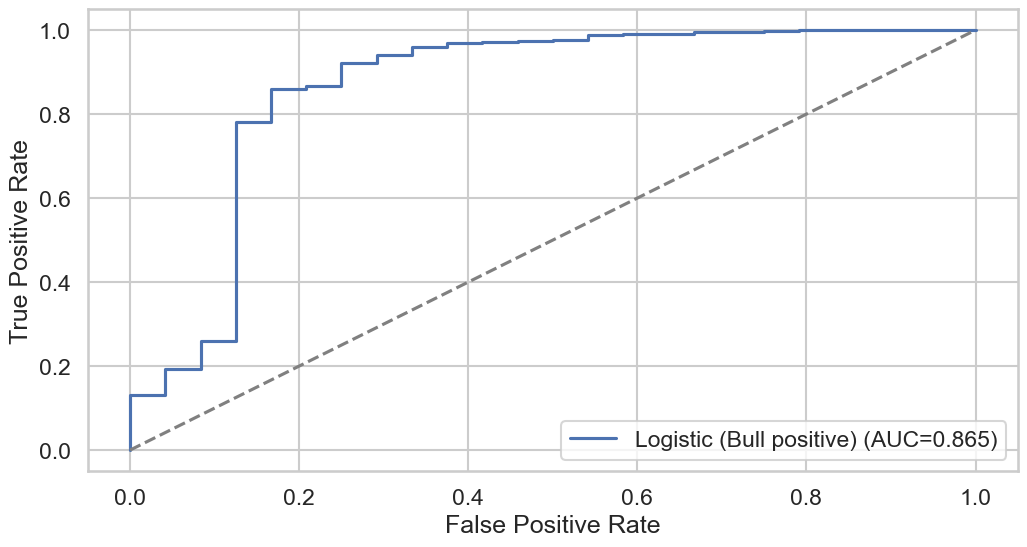

In [20]:
# plot ROC - AUC
plot_roc((y_val==0).astype(int), y_val_prob, label='Logistic (Bear positive)')
plot_roc((y_val==1).astype(int), 1 - y_val_prob, label='Logistic (Bull positive)')


Logistic Regression Feature Importance (SMOTETomek):
         feature      coef  abs_coef
0            VIX -5.787368  5.787368
3  TLT_SPY_ratio  3.284192  3.284192
2  Credit_Spread  1.933015  1.933015
1    Yield_Curve  0.131832  0.131832
4   SPY_ret_lag1 -0.020534  0.020534


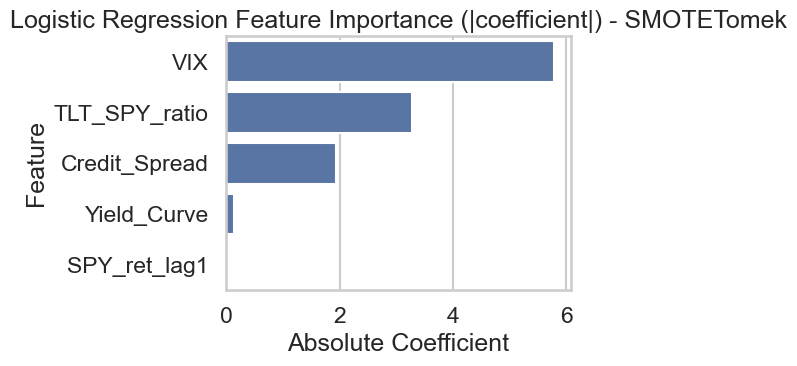

In [21]:
# Logistic Regression Coefficients (importance)
log_coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef': log_clf.coef_.ravel(),
    'abs_coef': np.abs(log_clf.coef_.ravel())
}).sort_values('abs_coef', ascending=False)

print("\nLogistic Regression Feature Importance (SMOTETomek):")
print(log_coef_df)

plt.figure(figsize=(6,4))
sns.barplot(data=log_coef_df, x='abs_coef', y='feature')
plt.title("Logistic Regression Feature Importance (|coefficient|) - SMOTETomek")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [22]:
# LASSO logistic regression using cross-validated C values.
# 'class_weight=balanced' helps with the imbalanced dataset.
# LogisticRegressionCV automatically selects the best regularization strength.
lasso = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear',class_weight=None, cv=5, max_iter=2000)
lasso.fit(X_train_res_s, y_train_res)

# Predict on validation set
y_val_pred_l = lasso.predict(X_val_s)
y_val_prob_l = lasso.predict_proba(X_val_s)[:, 0]  # prob of bear


Lasso Logistic Regression Feature Importance (SMOTETomek):
         feature      coef  abs_coef
0            VIX -5.110195  5.110195
3  TLT_SPY_ratio  2.851977  2.851977
2  Credit_Spread  1.729398  1.729398
1    Yield_Curve  0.109316  0.109316
4   SPY_ret_lag1  0.000000  0.000000


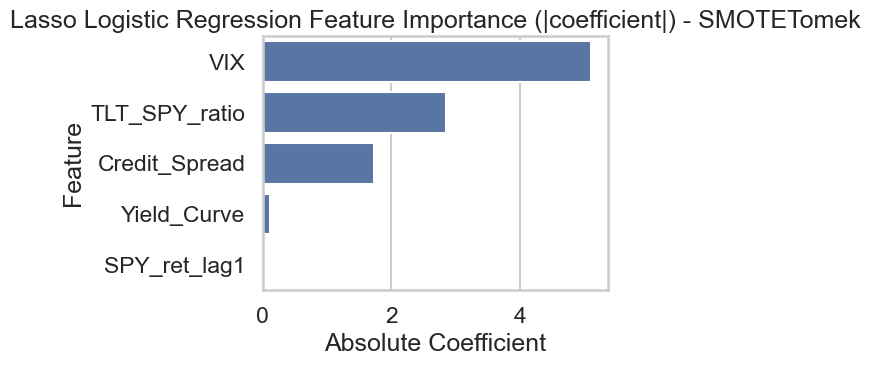

In [23]:
# Lasso Logistic Regression Coefficients (importance)
lasso_coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef': lasso.coef_.ravel(),
    'abs_coef': np.abs(lasso.coef_.ravel())
}).sort_values('abs_coef', ascending=False)

print("\nLasso Logistic Regression Feature Importance (SMOTETomek):")
print(lasso_coef_df)

plt.figure(figsize=(6,4))
sns.barplot(data=lasso_coef_df, x='abs_coef', y='feature')
plt.title("Lasso Logistic Regression Feature Importance (|coefficient|) - SMOTETomek")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [24]:
# Evaluate classification performance and ROC-AUC
print("\n=== Lasso Logistic Regression with SMOTETomek (Validation) ===")
print(classification_report(y_val, y_val_pred_l))
print("ROC-AUC (Bear as positive):", round(roc_auc_score((y_val==0).astype(int), y_val_prob_l), 3))
print_roc_auc_both_classes(y_val, y_val_prob_l, model_name='LassoLog (SMOTETomek)')


=== Lasso Logistic Regression with SMOTETomek (Validation) ===
              precision    recall  f1-score   support

           0       0.18      0.75      0.29        24
           1       0.99      0.89      0.94       733

    accuracy                           0.88       757
   macro avg       0.58      0.82      0.61       757
weighted avg       0.97      0.88      0.92       757

ROC-AUC (Bear as positive): 0.866
LassoLog (SMOTETomek) ROC-AUC (Bear=Positive): 0.866
LassoLog (SMOTETomek) ROC-AUC (Bull=Positive): 0.866


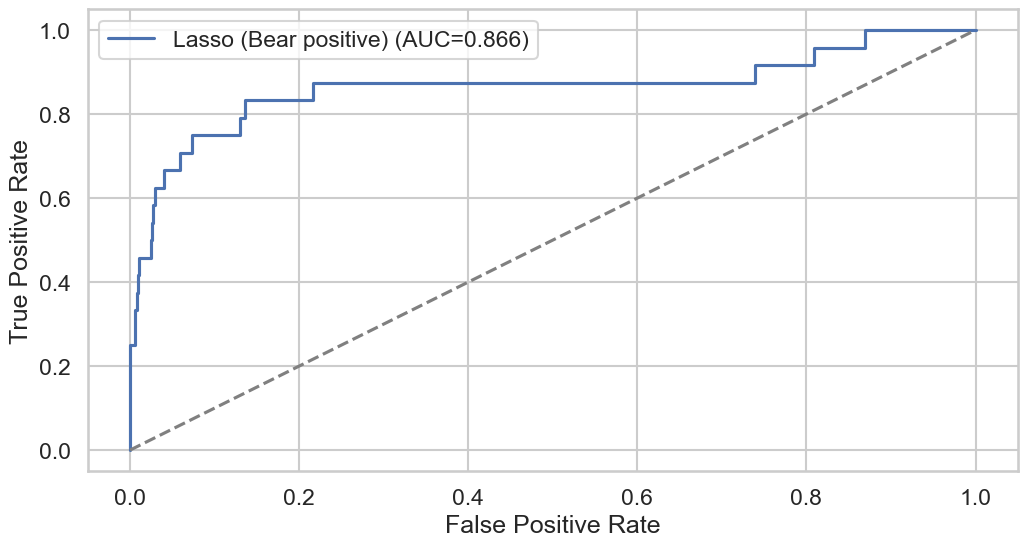

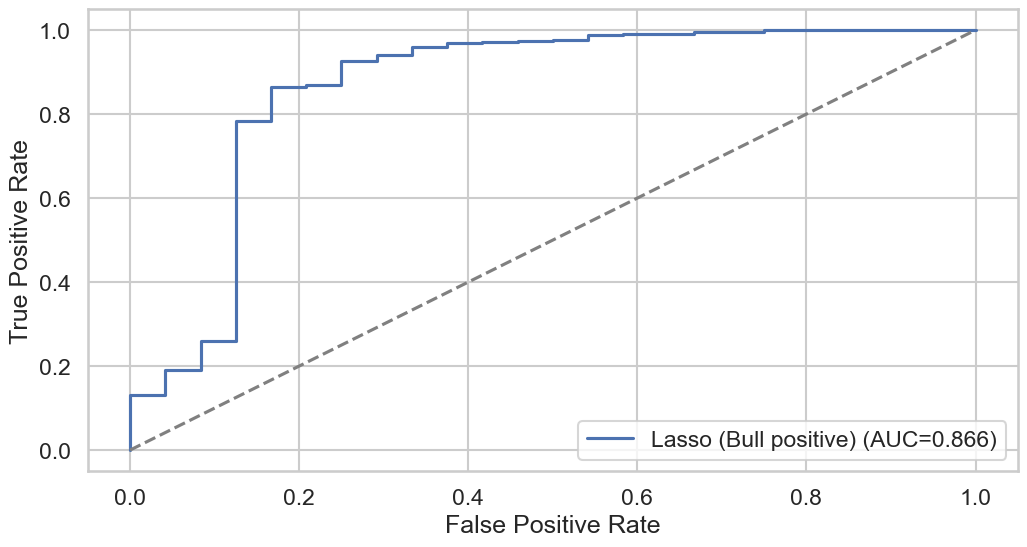

In [25]:
# Plot ROC - AUC
plot_roc((y_val == 0).astype(int), y_val_prob_l, label='Lasso (Bear positive)')
plot_roc((y_val == 1).astype(int), 1 - y_val_prob_l, label='Lasso (Bull positive)')

In [26]:
# Decision Tree with SMOTETomek
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42)
dt.fit(X_train_res, y_train_res)
y_val_prob_dt = dt.predict_proba(X_val)[:, 0]

# Threshold tuning for Decision Tree
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores_dt = []
for t in thresholds:
    pred_bear = (y_val_prob_dt > t).astype(int)
    y_val_pred_dt_temp = np.where(pred_bear == 1, 0, 1)
    f1_scores_dt.append(f1_score(y_val, y_val_pred_dt_temp, pos_label=0, zero_division=0))
best_t_dt = thresholds[np.argmax(f1_scores_dt)]
y_val_pred_dt = np.where((y_val_prob_dt > best_t_dt), 0, 1)

print("Decision Tree performance:")
print(classification_report(y_val, y_val_pred_dt))
print("ROC-AUC (Bear as positive):", roc_auc_score((y_val==0).astype(int), y_val_prob_dt))
print_roc_auc_both_classes(y_val, y_val_prob_dt, model_name='DecisionTree_SMOTETomek')

Decision Tree performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.97      1.00      0.98       733

    accuracy                           0.97       757
   macro avg       0.48      0.50      0.49       757
weighted avg       0.94      0.97      0.95       757

ROC-AUC (Bear as positive): 0.5
DecisionTree_SMOTETomek ROC-AUC (Bear=Positive): 0.500
DecisionTree_SMOTETomek ROC-AUC (Bull=Positive): 0.500


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


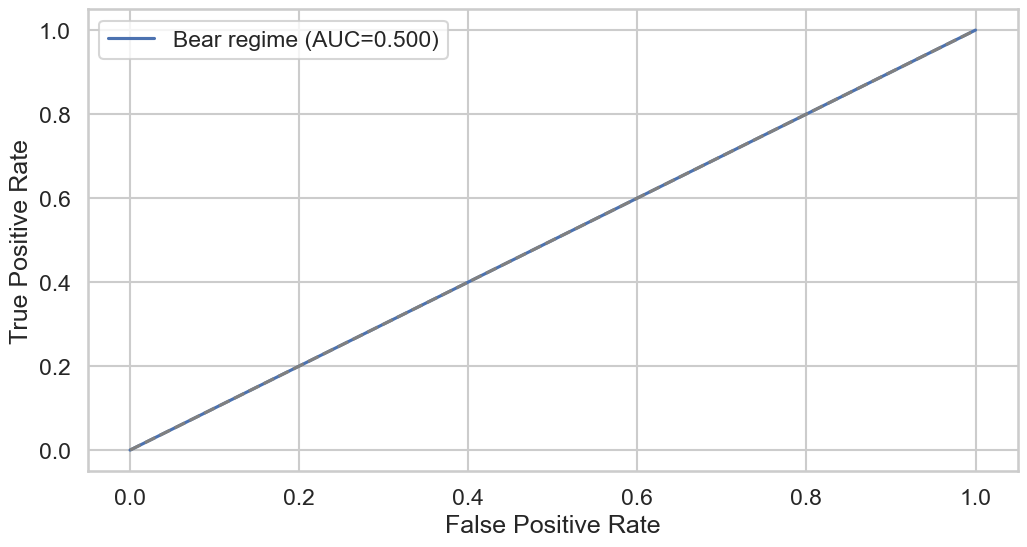

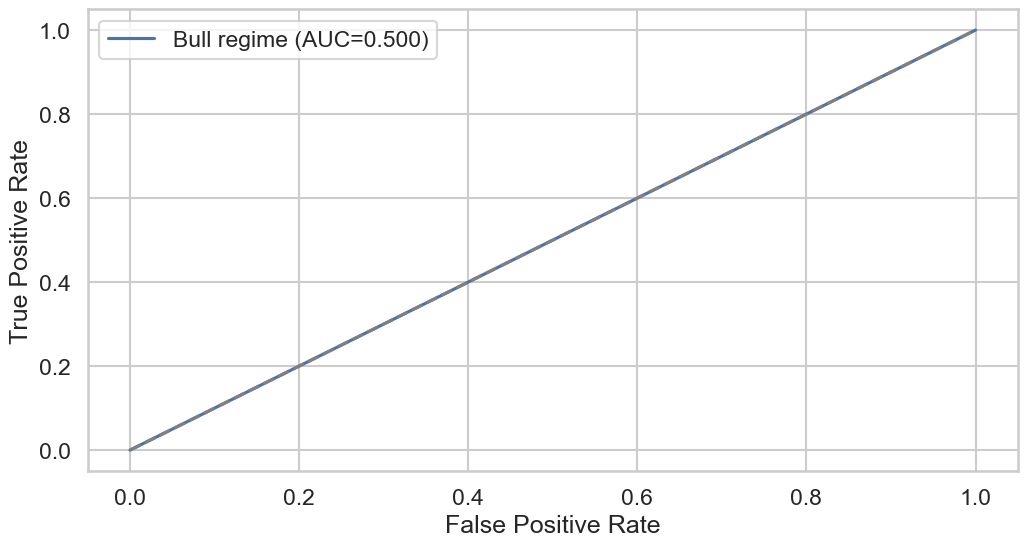

In [27]:
# ROC - AUC plots
plot_roc((y_val==0).astype(int), y_val_prob_dt, label='Bear regime')
plot_roc((y_val==1).astype(int), 1-y_val_prob_dt, label='Bull regime')


Decision Tree Feature Importance:
         feature  importance
2  Credit_Spread    0.504794
0            VIX    0.389033
1    Yield_Curve    0.071952
3  TLT_SPY_ratio    0.029931
4   SPY_ret_lag1    0.004290


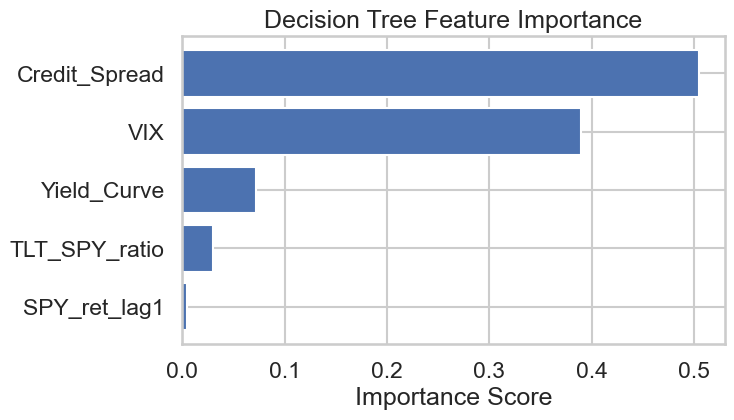

In [28]:
# Decision Tree Feature Importance
dt_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nDecision Tree Feature Importance:")
print(dt_importance)

# Plot
fi_dt = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(7,4))
plt.barh(fi_dt['feature'], fi_dt['importance'])
plt.xlabel("Importance Score")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

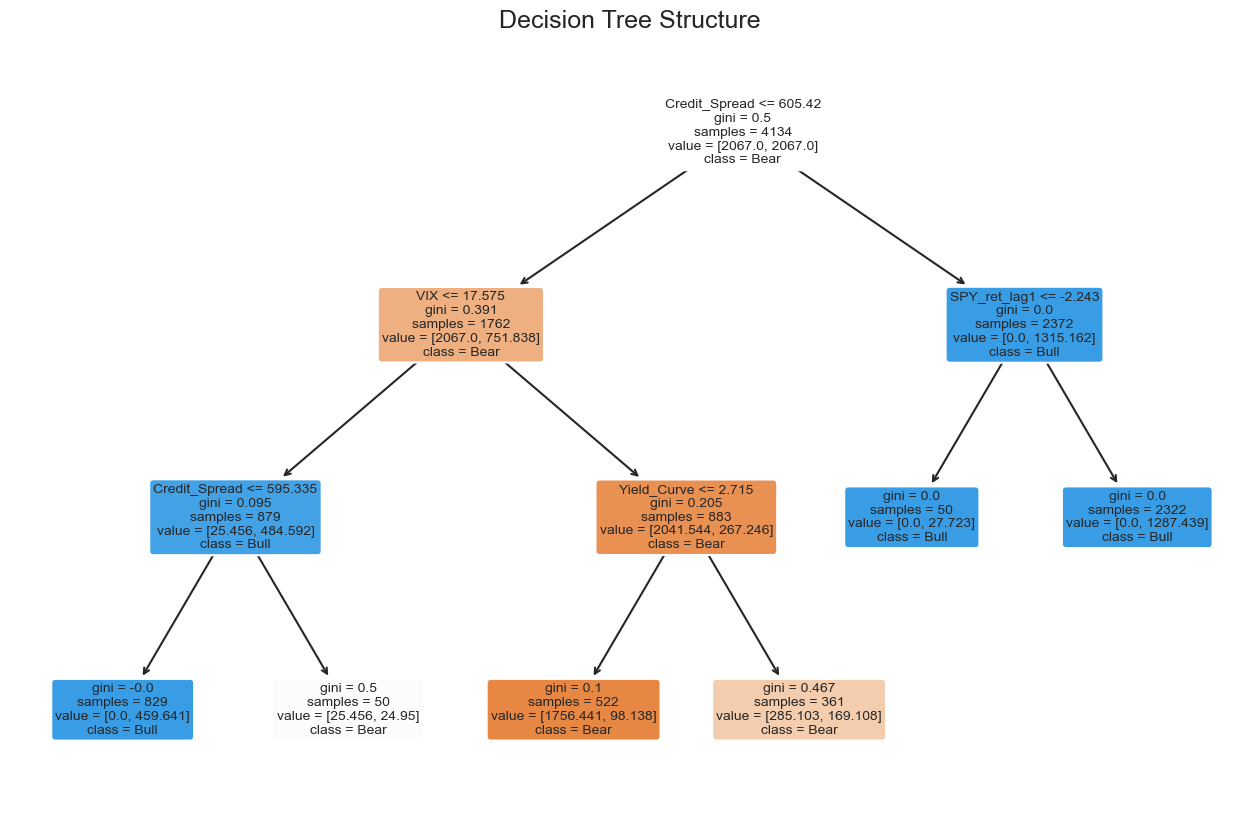

In [29]:
# Decision Tree Diagram
dt_small = DecisionTreeClassifier(
    max_depth=3,          
    min_samples_leaf=50,  
    random_state=42,
    class_weight='balanced'
)

dt_small.fit(X_train, y_train)   

plt.figure(figsize=(16, 10))
plot_tree(
    dt_small,
    feature_names=feature_cols,
    class_names=['Bear', 'Bull'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()

In [30]:
# Random Forest with SMOTETomek
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_val_prob_rf = rf.predict_proba(X_val)[:, 0]

In [31]:
# Threshold tuning for 
f1_scores_rf = []
for t in thresholds:
    pred_bear = (y_val_prob_rf > t).astype(int)
    y_val_pred_rf_temp = np.where(pred_bear == 1, 0, 1)
    f1_scores_rf.append(f1_score(y_val, y_val_pred_rf_temp, pos_label=0, zero_division=0))
best_t_rf = thresholds[np.argmax(f1_scores_rf)]
y_val_pred_rf = np.where((y_val_prob_rf > best_t_rf), 0, 1)

In [32]:
# Final evaluation at best threshold (use Random Forest)
print("\nConfusion matrix at best threshold:")
print(confusion_matrix(y_val, y_val_pred_rf))   
print("\nClassification report:")
print(classification_report(y_val, y_val_pred_rf))
print("ROC-AUC:", roc_auc_score((y_val==0).astype(int), y_val_prob_rf))
print_roc_auc_both_classes(y_val, y_val_prob_rf, model_name='RandomForest_SMOTETomek')


Confusion matrix at best threshold:
[[  0  24]
 [  0 733]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.97      1.00      0.98       733

    accuracy                           0.97       757
   macro avg       0.48      0.50      0.49       757
weighted avg       0.94      0.97      0.95       757

ROC-AUC: 0.594218963165075
RandomForest_SMOTETomek ROC-AUC (Bear=Positive): 0.594
RandomForest_SMOTETomek ROC-AUC (Bull=Positive): 0.594


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


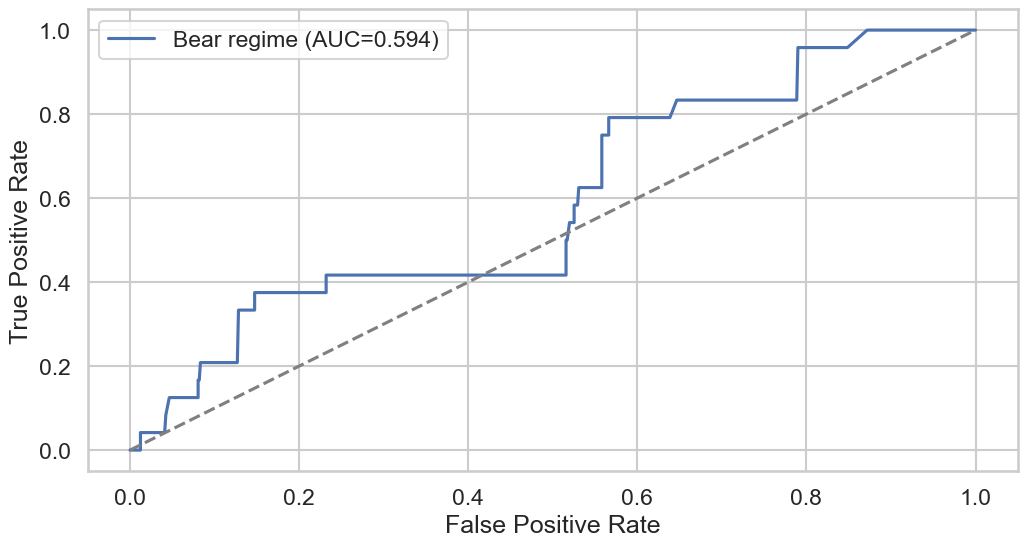

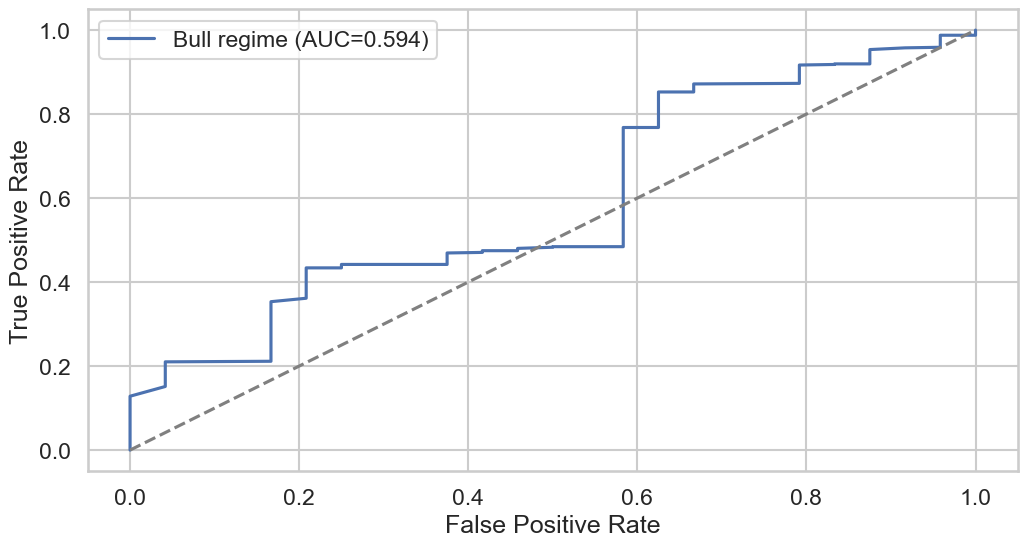

In [33]:
# ROC - AUC plots 
plot_roc((y_val==0).astype(int), y_val_prob_rf, label='Bear regime')
plot_roc((y_val==1).astype(int), 1-y_val_prob_rf, label='Bull regime')


Random Forest Feature Importance:
         feature  importance
2  Credit_Spread    0.431383
0            VIX    0.393847
1    Yield_Curve    0.091557
3  TLT_SPY_ratio    0.076707
4   SPY_ret_lag1    0.006505


/var/folders/3p/z9wtcy0n5gn8qfr58l89gwsh0000gn/T/ipykernel_32238/2516749108.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importance, x='importance', y='feature', palette='Greens')


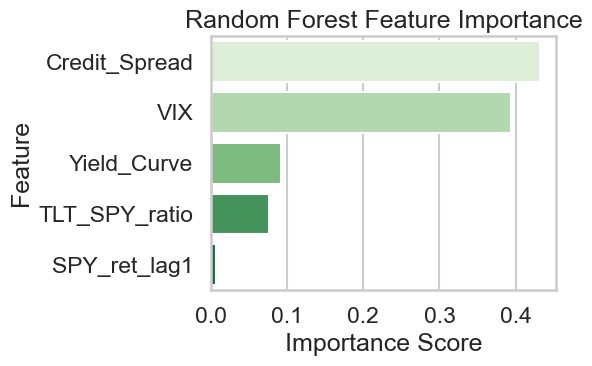

In [34]:
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=rf_importance, x='importance', y='feature', palette='Greens')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [35]:
# XGBoost with SMOTETomek

dtrain_smt = xgb.DMatrix(X_train_res, label=y_train_res)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

bst_smt = xgb.train(params, dtrain_smt, num_boost_round=200,
                    evals=[(dval, 'val')],
                    early_stopping_rounds=20, verbose_eval=False)
y_val_prob_xgb = 1 - bst_smt.predict(dval)  

In [36]:
# Threshold tuning for bear regime
f1_scores_xgb = []
thresholds = np.arange(0.1, 1.0, 0.1)
for t in thresholds:
    pred_bear = (y_val_prob_xgb > t).astype(int)
    y_val_pred_xgb_temp = np.where(pred_bear == 1, 0, 1)
    f1_scores_xgb.append(f1_score(y_val, y_val_pred_xgb_temp, pos_label=0, zero_division=0))
best_t_xgb = thresholds[np.argmax(f1_scores_xgb)]
y_val_pred_xgb = np.where((y_val_prob_xgb > best_t_xgb), 0, 1)  

In [37]:
# Final evaluation at best threshold
print("\nConfusion matrix at best threshold:")
print(confusion_matrix(y_val, y_val_pred_xgb))
print("\nClassification report at best threshold:")
print(classification_report(y_val, y_val_pred_xgb))
print("ROC-AUC:", roc_auc_score((y_val == 0).astype(int), y_val_prob_xgb))
print_roc_auc_both_classes(y_val, y_val_prob_xgb, model_name='XGBoost_SMOTETomek')


Confusion matrix at best threshold:
[[ 13  11]
 [271 462]]

Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.05      0.54      0.08        24
           1       0.98      0.63      0.77       733

    accuracy                           0.63       757
   macro avg       0.51      0.59      0.43       757
weighted avg       0.95      0.63      0.74       757

ROC-AUC: 0.5915472942246476
XGBoost_SMOTETomek ROC-AUC (Bear=Positive): 0.592
XGBoost_SMOTETomek ROC-AUC (Bull=Positive): 0.592


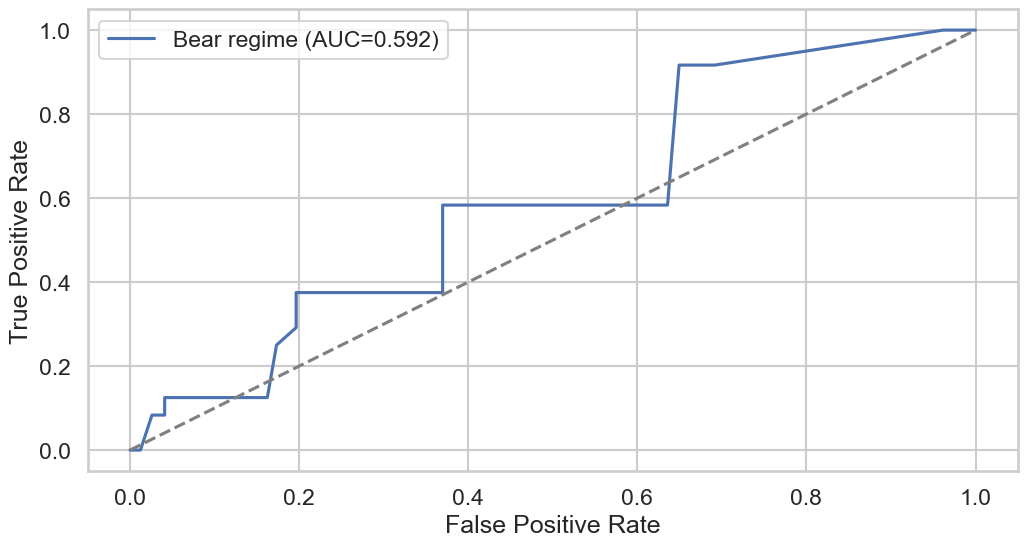

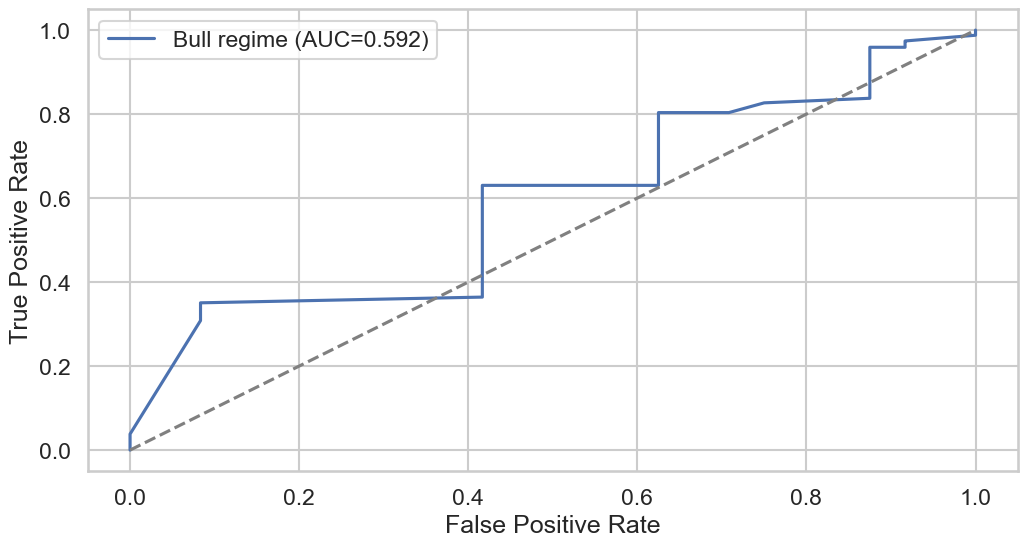

In [38]:
# ROC - AUC plots 
plot_roc((y_val==0).astype(int), y_val_prob_xgb, label='Bear regime')
plot_roc((y_val==1).astype(int), 1-y_val_prob_xgb, label='Bull regime')


XGBoost Feature Importance:

         feature  importance
2  Credit_Spread  476.452576
0            VIX  457.408447
3  TLT_SPY_ratio  179.612366
1    Yield_Curve  109.182487


/var/folders/3p/z9wtcy0n5gn8qfr58l89gwsh0000gn/T/ipykernel_32238/3873349318.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_importance, x='importance', y='feature', palette='Oranges')


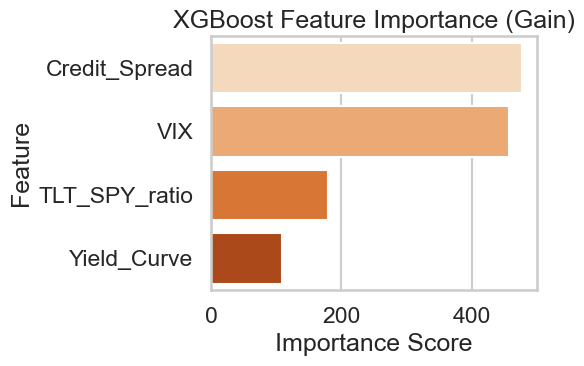

In [39]:
# Get importance from XGBoost (gain-based)
xgb_raw = bst_smt.get_score(importance_type='gain')

# Convert raw dict to DataFrame
xgb_importance = pd.DataFrame({
    "feature": list(xgb_raw.keys()),
    "importance": list(xgb_raw.values())
}).sort_values("importance", ascending=False)

print("\nXGBoost Feature Importance:\n")
print(xgb_importance)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=xgb_importance, x='importance', y='feature', palette='Oranges')
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [40]:
# create a simple comparison table

def metrics_table(y_true, preds_dict, probs_dict=None):
    rows = []
    for name, pred in preds_dict.items():
        prob = probs_dict.get(name) if probs_dict else None

        recall_bear = recall_score(y_true, pred, pos_label=0, zero_division=0)
        prec_bear = precision_score(y_true, pred, pos_label=0, zero_division=0)
        f1_bear    = f1_score(y_true, pred, pos_label=0, zero_division=0)

        recall_bull = recall_score(y_true, pred, pos_label=1, zero_division=0)
        prec_bull   = precision_score(y_true, pred, pos_label=1, zero_division=0)
        f1_bull     = f1_score(y_true, pred, pos_label=1, zero_division=0)

        acc = accuracy_score(y_true, pred)

        auc_bear = roc_auc_score((y_true == 0).astype(int), prob) if prob is not None else None
        auc_bull = roc_auc_score((y_true == 1).astype(int), 1 - prob) if prob is not None else None

        rows.append({
            'model': name,
            'accuracy': acc,
            'precision_bear': prec_bear,
            'recall_bear': recall_bear,
            'f1_bear': f1_bear,
            'auc_bear': auc_bear,
            'precision_bull': prec_bull,
            'recall_bull': recall_bull,
            'f1_bull': f1_bull,
            'auc_bull': auc_bull,
        })
    return pd.DataFrame(rows) \
             .sort_values('recall_bear', ascending=False) \
             .reset_index(drop=True)

preds = {
    'Logistic': y_val_pred,
    'LassoLog': y_val_pred_l,
    'DecisionTree_SMOTETomek': y_val_pred_dt,
    'RandomForest_SMOTETomek': y_val_pred_rf,
    'XGBoost_SMOTETomek': y_val_pred_xgb
}
probs = {
    'Logistic': y_val_prob,
    'LassoLog': y_val_prob_l,
    'DecisionTree_SMOTETomek': y_val_prob_dt,
    'RandomForest_SMOTETomek': y_val_prob_rf,
    'XGBoost_SMOTETomek': y_val_prob_xgb
}

metrics_df = metrics_table(y_val, preds, probs)
print(metrics_df.round(2))

                     model  accuracy  precision_bear  recall_bear  f1_bear  \
0                 Logistic      0.88            0.17         0.75     0.28   
1                 LassoLog      0.88            0.18         0.75     0.29   
2       XGBoost_SMOTETomek      0.63            0.05         0.54     0.08   
3  DecisionTree_SMOTETomek      0.97            0.00         0.00     0.00   
4  RandomForest_SMOTETomek      0.97            0.00         0.00     0.00   

   auc_bear  precision_bull  recall_bull  f1_bull  auc_bull  
0      0.87            0.99         0.88     0.93      0.87  
1      0.87            0.99         0.89     0.94      0.87  
2      0.59            0.98         0.63     0.77      0.59  
3      0.50            0.97         1.00     0.98      0.50  
4      0.59            0.97         1.00     0.98      0.59  


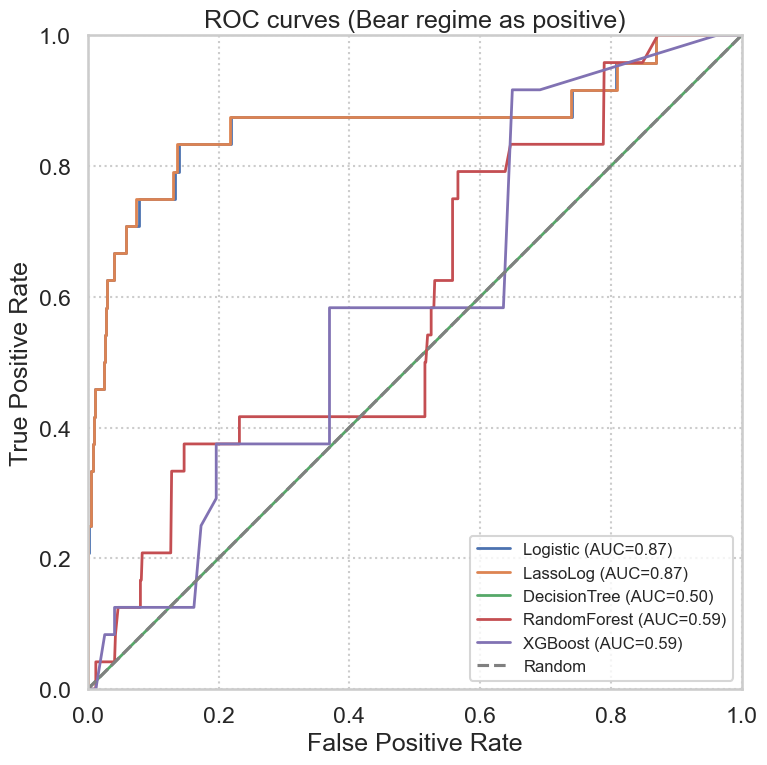

In [41]:
# plot ROC - AUC for selected models

plt.figure(figsize=(12, 8)) 

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve((y_val==0).astype(int), y_val_prob)
auc_log = roc_auc_score((y_val==0).astype(int), y_val_prob)
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.2f})", linewidth=2)

# Lasso Logistic Regression
fpr_lasso, tpr_lasso, _ = roc_curve((y_val==0).astype(int), y_val_prob_l)
auc_lasso = roc_auc_score((y_val==0).astype(int), y_val_prob_l)
plt.plot(fpr_lasso, tpr_lasso, label=f"LassoLog (AUC={auc_lasso:.2f})", linewidth=2)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve((y_val==0).astype(int), y_val_prob_dt)
auc_dt = roc_auc_score((y_val==0).astype(int), y_val_prob_dt)
plt.plot(fpr_dt, tpr_dt, label=f"DecisionTree (AUC={auc_dt:.2f})", linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve((y_val==0).astype(int), y_val_prob_rf)
auc_rf = roc_auc_score((y_val==0).astype(int), y_val_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.2f})", linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve((y_val==0).astype(int), y_val_prob_xgb)
auc_xgb = roc_auc_score((y_val==0).astype(int), y_val_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.2f})", linewidth=2)

plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random')  # Diagonal

plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_aspect('equal', adjustable='box')  # Square ratio
plt.grid(True, linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (Bear regime as positive)")
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

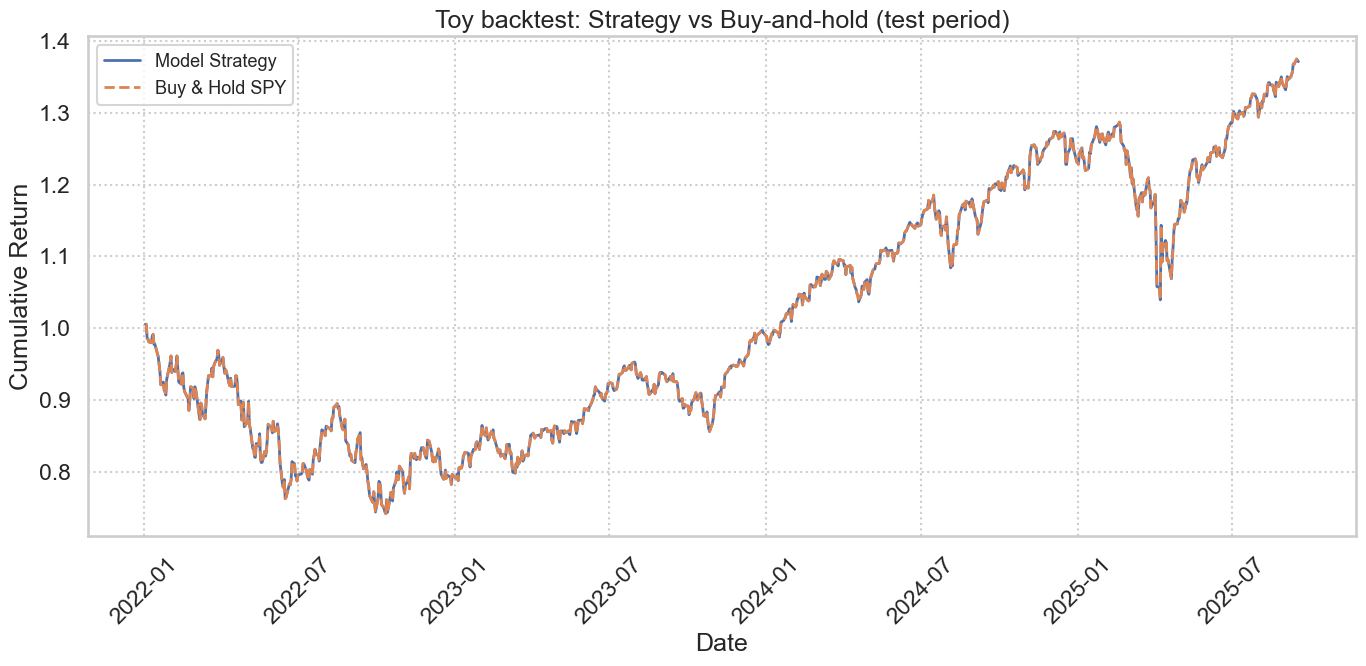

Strategy final return: 1.37
SPY final return: 1.37


In [42]:
# Predict on test set using the threshold-tuned Random Forest
test_X = df[test_idx][feature_cols]
test_prob_rf = rf.predict_proba(test_X)[:, 0]                           
test_pred = np.where((test_prob_rf > best_t_rf), 0, 1)            

test_df = df[test_idx].copy().reset_index(drop=True)
test_df['predicted_regime'] = test_pred 
test_df['SPY_ret_dec'] = test_df['SPY_ret'] / 100.0
test_df['Bond_ret_dec'] = -0.2 * test_df['SPY_ret_dec']
test_df['strategy_ret'] = np.where(test_df['predicted_regime'] == 0, test_df['Bond_ret_dec'], test_df['SPY_ret_dec'])
test_df['strategy_cum'] = (1 + test_df['strategy_ret']).cumprod()
test_df['spy_cum'] = (1 + test_df['SPY_ret_dec']).cumprod()

plt.figure(figsize=(14,7))
plt.plot(test_df['Date'], test_df['strategy_cum'], label='Model Strategy', linewidth=2)
plt.plot(test_df['Date'], test_df['spy_cum'], label='Buy & Hold SPY', linewidth=2, linestyle="--")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Toy backtest: Strategy vs Buy-and-hold (test period)")
plt.grid(True, linestyle=':')
plt.legend(loc="upper left", fontsize=13)
plt.tight_layout()
plt.show()

print("Strategy final return:", round(test_df['strategy_cum'].iloc[-1], 2))
print("SPY final return:", round(test_df['spy_cum'].iloc[-1], 2))